In [46]:
# https://drive.google.com/drive/folders/1idNpDd9aEE2j5w7Uc9Tja92ekRIt8hKd?usp=sharing

In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
from nltk.util import ngrams
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
def text_preprocessing(string, keep_stop=False, keep_num=True, min_len=1):
    string = str(string)
    string = string.lower()
    tokens = word_tokenize(string)
    if keep_num:
        words = [word for word in tokens if  word.isalnum() ]
    else:
        words = [word for word in tokens if  word.isalpha() ]
    if not keep_stop:
        sw_en = set(stopwords.words('english'))
        words_clean = [word for word in words if word not in sw_en and len(word)>=min_len]
    else:
        words_clean = [word for word in words if len(word)>=min_len]
    return words_clean

def text_stem(string, keep_stop=False, keep_num=True, min_len=1):
    stemmer = PorterStemmer()
    tokens = text_preprocessing(string, keep_stop, keep_num, min_len)
    words_stem = [stemmer.stem(word) for word in tokens]
    return words_stem

def text_lemma(string, keep_stop=False, keep_num=True, min_len=1):
    lemmatizer = WordNetLemmatizer()
    tokens = text_preprocessing(string, keep_stop, keep_num, min_len)
    words_lemma = [lemmatizer.lemmatize(word) for word in tokens]
    return words_lemma

In [18]:
# exercício ------------------------------------------------
fake = pd.read_csv('data/train_fakenews.csv')
fake.drop(columns=['id', 'title', 'author'], inplace=True)
fake.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [50]:
#fake['tokens_with_stop'] = fake['text'].apply(lambda x: text_preprocessing(x, keep_stop=True, keep_num=True, min_len=1)) # tratamento básico
#fake['tokens_no_stop'] = fake['text'].apply(lambda x: text_preprocessing(x, keep_stop=False, keep_num=False, min_len=3)) # tratamento básico
#fake['stem_words'] = fake['text'].apply(lambda x: text_stem(x, keep_stop=False, keep_num=False, min_len=3)) # pegando só o words_stem
fake['lemma_words'] = fake['text'].apply(lambda x: text_lemma(x, keep_stop=False, keep_num=False, min_len=3)) # pegando só o words_lemma
fake['lemma_string'] = fake['lemma_words'].apply(lambda x: ' '.join(x))

fake['lemma_bigram'] = fake['lemma_words'].apply(lambda x: list(ngrams(x, 2)))

In [51]:
fake.dropna(inplace=True)
fake.head()

,text,label,lemma_words,lemma_bigram,lemma_string
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[house, dem, aide, even, see, comey, letter, j...","[(house, dem), (dem, aide), (aide, even), (eve...",house dem aide even see comey letter jason cha...
1,Ever get the feeling your life circles the rou...,0,"[ever, get, feeling, life, circle, roundabout,...","[(ever, get), (get, feeling), (feeling, life),...",ever get feeling life circle roundabout rather...
2,"Why the Truth Might Get You Fired October 29, ...",1,"[truth, might, get, fired, october, tension, i...","[(truth, might), (might, get), (get, fired), (...",truth might get fired october tension intellig...
3,Videos 15 Civilians Killed In Single US Airstr...,1,"[video, civilian, killed, single, airstrike, i...","[(video, civilian), (civilian, killed), (kille...",video civilian killed single airstrike identif...
4,Print \nAn Iranian woman has been sentenced to...,1,"[print, iranian, woman, sentenced, six, year, ...","[(print, iranian), (iranian, woman), (woman, s...",print iranian woman sentenced six year prison ...


In [52]:
fake.isnull().sum()

text            0
label           0
lemma_words     0
lemma_bigram    0
lemma_string    0
dtype: int64

In [23]:
fake_0 = fake[fake['label']==0].reset_index(drop=True)
freq_0 = nltk.FreqDist([x for sublist in fake_0['lemma_words'].to_list() for x in sublist])
freq_0_bi = nltk.FreqDist([x for sublist in fake_0['lemma_bigram'].to_list() for x in sublist])

fake_1 = fake[fake['label']==1].reset_index(drop=True)
freq_1 = nltk.FreqDist([x for sublist in fake_1['lemma_words'].to_list() for x in sublist])
freq_1_bi = nltk.FreqDist([x for sublist in fake_1['lemma_bigram'].to_list() for x in sublist])

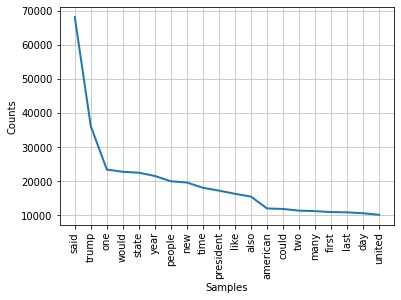

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
freq_0.plot(20, cumulative=False)

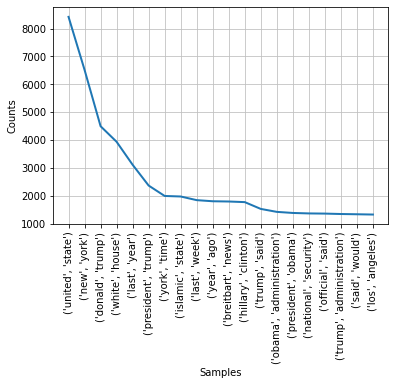

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [25]:
freq_0_bi.plot(20, cumulative=False)

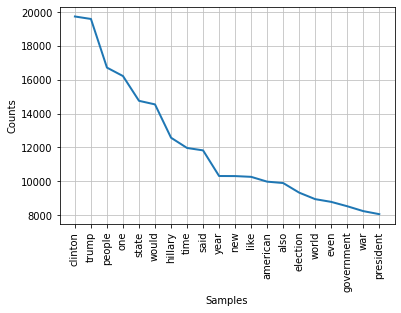

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
freq_1.plot(20, cumulative=False)

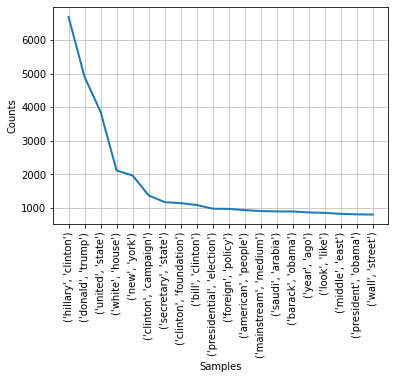

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
freq_1_bi.plot(20, cumulative=False)

In [54]:
X = fake['lemma_string']
y = fake['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
class DenseTransformer():
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [71]:
gscv = StratifiedKFold(n_splits=3, shuffle=True)

algorithms = {
    'logistic':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('log', LogisticRegression())]), 
        param_grid={
            'log__penalty': ['l1', 'l2'],
            'log__solver': ['liblinear'],
        },
        scoring=['roc_auc', 'f1', 'accuracy'],
        refit='f1',
        cv=gscv),

    'randomforest':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('rf', RandomForestClassifier())]), 
        param_grid={
            'rf__max_depth': [5, 20],
            'rf__criterion': ['entropy', 'gini'],
        },
        scoring=['roc_auc', 'f1', 'accuracy'],
        cv=gscv),

    'randomforest_pca':  GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('to_dense', DenseTransformer()),
            ('pca', PCA(n_components=50)),
            ('rf', RandomForestClassifier())]), 
        param_grid={
            'rf__max_depth': [5, 20],
            'rf__criterion': ['entropy', 'gini'],
        },
        scoring=['roc_auc', 'f1', 'accuracy'],
        cv=gscv),
        
    'svmrbf': GridSearchCV(
        Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('svm', SVC(kernel='rbf'))]), 
        param_grid={
            'pca__n_components': [2, 10],
            'svm__C': [1.0],
            'svm__gamma': [0.1, 2.0],
        },
        scoring=['roc_auc', 'f1', 'accuracy'],
        cv=gscv),
}

In [72]:
results = {}
t = datetime.now()

for alg, clf in algorithms.items():
    t0 = datetime.now()
    clf.fit(X_train, y_train) 
    t1 = datetime.now()
    results[alg] = clf.cv_results_
    print(f"Algorítmo treinado: {alg}\t Duração: {t1-t0}")

print(f"\nTempo total: {t1-t}")
results = pd.DataFrame.from_dict(results)

Algorítmo treinado: logistic	 Duração: 0:01:14.814121

Tempo total: 0:01:14.814121


In [73]:
result

,logistic
mean_fit_time,"[6.234514951705933, 6.774506092071533]"
mean_score_time,"[4.504025936126709, 4.492668469746907]"
mean_test_accuracy,"[0.9162537847508946, 0.9256124415083953]"
mean_test_f1,"[0.9167300194788263, 0.9257891961421332]"
mean_test_roc_auc,"[0.9715861399920467, 0.9783801200996969]"
param_log__penalty,"[l1, l2]"
param_log__solver,"[liblinear, liblinear]"
params,"[{'log__penalty': 'l1', 'log__solver': 'liblin..."
rank_test_accuracy,"[2, 1]"
rank_test_f1,"[2, 1]"
